# Automated Analysis of Course Content Alignment and Learning Outcomes on Coursera

## 1.0  Broilerplate and Loading the Corpus

In [116]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, LangDetectException
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS


courses_df = pd.read_csv("scraped_coursera_data.csv")
courses_df.drop(columns=["Unnamed: 0"], inplace=True)
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   course_title        962 non-null    object 
 1   org                 943 non-null    object 
 2   cert_type           962 non-null    object 
 3   enrolled            962 non-null    object 
 4   series_type         962 non-null    object 
 5   rating              960 non-null    float64
 6   num_reviews         961 non-null    float64
 7   difficulty          962 non-null    object 
 8   url                 1000 non-null   object 
 9   duration            962 non-null    object 
 10  what_youll_learn    586 non-null    object 
 11  skills_youll_gain   747 non-null    object 
 12  details_to_know     962 non-null    object 
 13  course_outcomes     654 non-null    object 
 14  course_description  962 non-null    object 
 15  course_details      955 non-null    object 
dtypes: floa

## 2.0  Data Pre-Processing and Exploratory Data Analysis

### 2.1 Data Cleaning

Handle Missing Values

Missing Values:course_title           38
org                    57
cert_type              38
enrolled               38
series_type            38
rating                 40
num_reviews            39
difficulty             38
url                     0
duration               38
what_youll_learn      414
skills_youll_gain     253
details_to_know        38
course_outcomes       346
course_description     38
course_details         45
dtype: int64


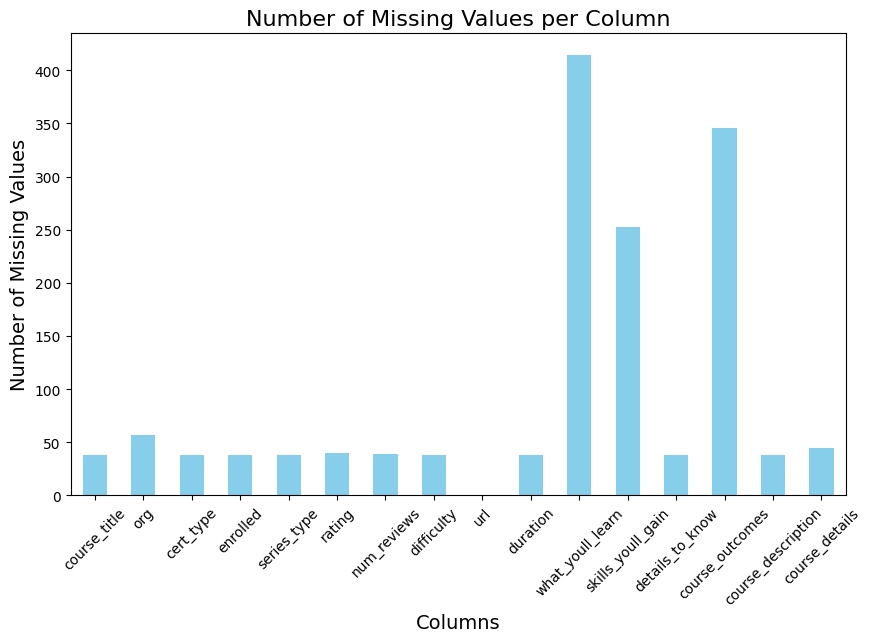

Number of rows after removing empty rows: 1000


C:\Users\somes\AppData\Local\Temp\ipykernel_22420\4094141964.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  courses_df[col].fillna('Unknown', inplace=True)
C:\Users\somes\AppData\Local\Temp\ipykernel_22420\4094141964.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [117]:
### 1. Handle Missing Values ###
print(f"Missing Values:{courses_df.isnull().sum()}")

# Calculate the number of missing values in each column
missing_values = courses_df.isnull().sum()

# Plot the missing values
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Number of Missing Values per Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Number of Missing Values', fontsize=14)
plt.xticks(rotation=45)

#Save the plotted image into image folder
plt.savefig('images/missing_values.png')

plt.show()

#Remove rows if the entire row is missing
courses_df.dropna(how='all', inplace=True)
print(f"Number of rows after removing empty rows: {courses_df.shape[0]}")

# Fill missing categorical values with 'Unknown'
categorical_cols = ['course_title', 'org', 'series_type', 'difficulty', 'duration']
for col in categorical_cols:
    courses_df[col].fillna('Unknown', inplace=True)

# Fill missing text columns with empty strings
text_cols = courses_df.select_dtypes(include='object').columns
for col in text_cols:
    courses_df[col].fillna('', inplace=True)

View the non-English Courses

DataFrame with Language Detection:
                                          course_title  \
0    ISC2 Systems Security Certified Practitioner (...   
1              .NET FullStack Developer Specialization   
2    21st Century Energy Transition: how do we make...   
3    A Crash Course in Causality:  Inferring Causal...   
4                                     A life with ADHD   
..                                                 ...   
995  Étudier en France: French Intermediate course ...   
996  Google Digital Marketing & E-commerce Professi...   
997     Google Data Analytics Professional Certificate   
998  用 Python 做商管程式設計（一）(Programming for Business C...   
999  用 Python 做商管程式設計（二）(Programming for Business C...   

                            org                 cert_type   enrolled  \
0                          ISC2            Specialization     22,115   
1               Board Infinity             Specialization     11,392   
2         University of Alberta                    C

C:\Users\somes\AppData\Local\Temp\ipykernel_22420\1138975533.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=courses_df, x='language', palette='viridis')


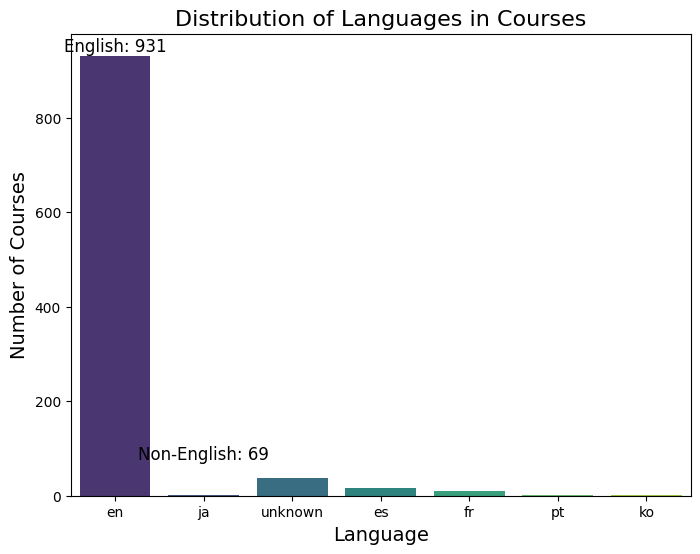

Rows left after removing non-english courses:931


In [118]:
#View the non-english courses
# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Detect language for each row based on the 'course_description' column
courses_df['language'] = courses_df['course_description'].apply(detect_language)

# View the DataFrame with the new 'language' column
print("DataFrame with Language Detection:")
print(courses_df)

# Count the number of English and non-English courses
language_counts = courses_df['language'].value_counts()
english_count = language_counts.get('en', 0)  # Get count of English courses
non_english_count = len(courses_df) - english_count  # Calculate non-English courses

# Plot the value counts of the 'language' column with the exact number
plt.figure(figsize=(8, 6))
sns.countplot(data=courses_df, x='language', palette='viridis')
plt.title('Distribution of Languages in Courses', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Number of Courses', fontsize=14)
plt.text(0, english_count, f'English: {english_count}', ha='center', va='bottom', fontsize=12)
plt.text(1, non_english_count, f'Non-English: {non_english_count}', ha='center', va='bottom', fontsize=12)

plt.savefig('images/language_distribution.png')

plt.show()

# Remove the non-english courses
courses_df = courses_df[courses_df['language'] == 'en']
courses_df.drop(columns=['language'], inplace=True)
courses_df.reset_index(drop=True, inplace=True)
print(f"Rows left after removing non-english courses:{courses_df.shape[0]}")

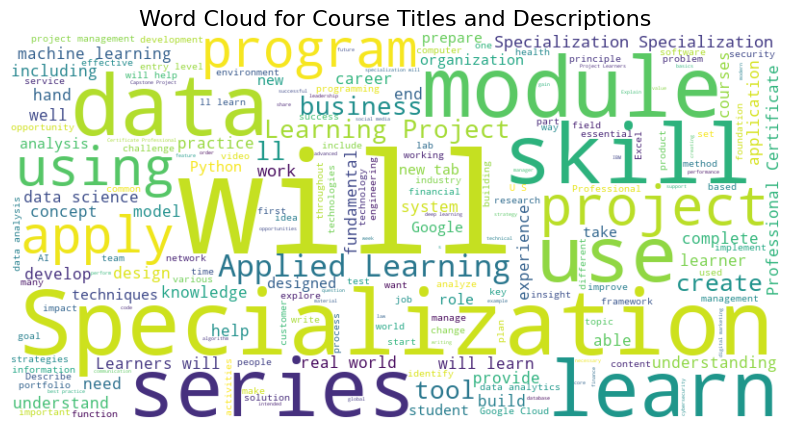

In [119]:
# Combine all text from relevant columns into a single string
text_data = ' '.join(courses_df['course_title'] + ' ' + courses_df['course_description'])

#Add custom stopwords (optional)
wordcloud_stopwords = set(STOPWORDS)
wordcloud_stopwords.update(["course", "introduction", "basic"])  # Add words to exclude

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    stopwords=wordcloud_stopwords
).generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Course Titles and Descriptions', fontsize=16)
plt.show()

# Save the word cloud as an image file (optional)
wordcloud.to_file('images/NLP word cloud.png')

Remove stopwords    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\somes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


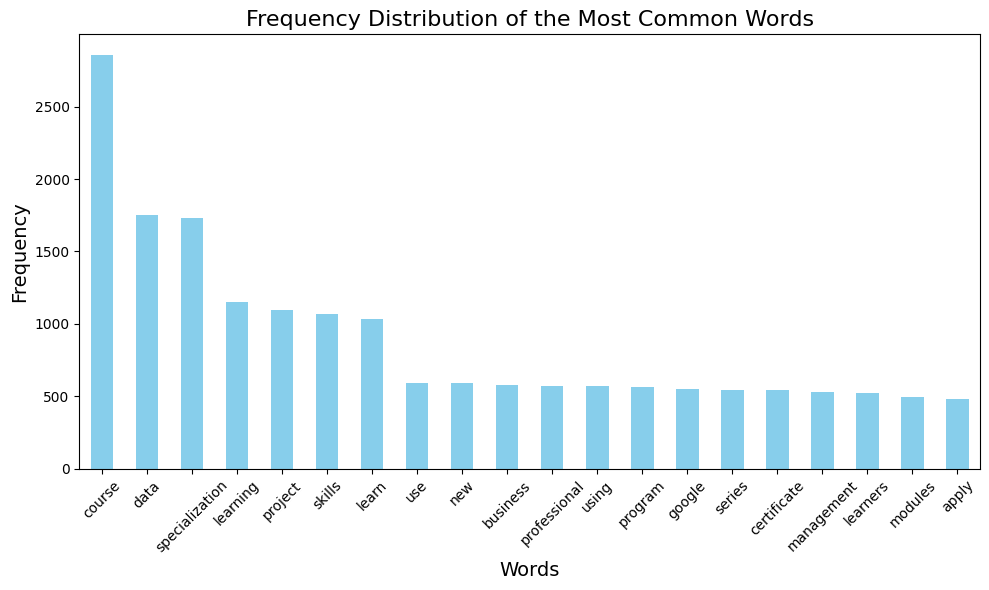

In [120]:
# Remove stopwords
nltk.download('stopwords')

# Get the stopword list for English
stopwords_set = set(stopwords.words('english'))  # Correct variable name

# Define text preprocessing function
def tokenize_text(text):
    if not isinstance(text, str):
        return ""  # Handle non-string cases safely
    tokens = re.sub(r'[^a-zA-Z]', ' ', text)  # Replace non-alphabetic characters with space
    tokens = tokens.lower().split()  # Convert to lowercase and split into words
    return [word for word in tokens if word not in stopwords_set]  # Remove stopwords

# Example text data (ensure text_data is defined)
if "text_data" in locals():
    tokens = tokenize_text(text_data)

    # Convert the tokenized words back into a string
    filtered_text = ' '.join(tokens)

    # Plot frequency distribution of the most common words
    plt.figure(figsize=(10, 6))
    word_freq[:20].plot(kind='bar', color='skyblue')
    plt.title('Frequency Distribution of the Most Common Words', fontsize=16)
    plt.xlabel('Words', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()  # Ensure labels fit properly

    # Save the plot BEFORE calling plt.show()
    plt.savefig('images/frequency_distribution.png', bbox_inches='tight', dpi=300)

    # Show the figure
    plt.show()

In [121]:
courses_df.shape[0]

931

- "course_title" is unique
- "org" has sizeable clusters
- "enrolled" shold be an int
- "series type" should also be an int
- "difficulty" can be transformed into categorical, some inputs mixed up with "duration"
- "duration" is a messy datatype: need to use some text/classification method
- "course_outcomes" needs some processing but could be somewhat categorical

- "what_youll_learn", "skills_youll_gain", "course_description", "course_details" are the corpus elements

- "details_to_know" feels abit weird - doesnt provide much info

In [122]:
df.describe()

NameError: name 'df' is not defined

array([[<Axes: title={'center': 'enrolled'}>,
        <Axes: title={'center': 'rating'}>],
       [<Axes: title={'center': 'num_reviews'}>, <Axes: >]], dtype=object)

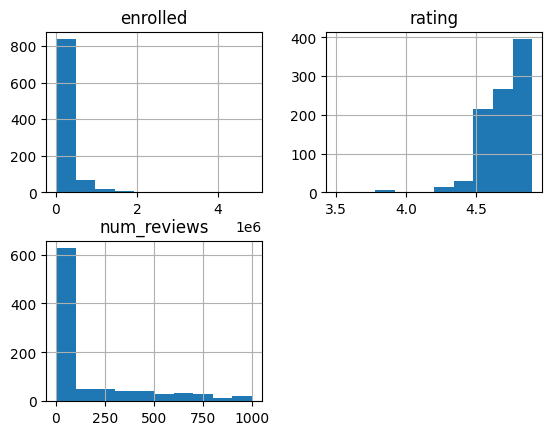

In [ ]:
# for the 2 numerical variables:

df.hist()